# A. Nhập dữ liệu

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import math # thư viện math

#LSTM
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from tensorflow.keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất


#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_percentage_error #đo MAPE
from sklearn.metrics import mean_squared_error #MSE để tính RMSE

import warnings
warnings.filterwarnings("ignore")

In [2]:
#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# đọc dữ liệu từ file csv
df_train = pd.read_csv('/content/drive/MyDrive/2025/data_goc/train.csv',parse_dates=['Date'])
df_test = pd.read_csv('/content/drive/MyDrive/2025/data_goc/test.csv',parse_dates=['Date'])

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901561 entries, 0 to 901560
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ProductID  901561 non-null  int64         
 1   Date       901561 non-null  datetime64[ns]
 2   Zip        901561 non-null  int64         
 3   Units      901561 non-null  int64         
 4   Revenue    901561 non-null  float64       
 5   COGS       901561 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 41.3 MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ProductID  74682 non-null  int64         
 1   Date       74682 non-null  datetime64[ns]
 2   Zip        74682 non-null  int64         
 3   Units      74682 non-null  int64         
 4   Revenue    74641 non-null  float64       
 5   COGS       74682 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 3.4 MB


In [6]:
# Kích thước của tập train
print(f"Tập train bao gồm {df_train.shape[0]} dòng và {df_train.shape[1]} cột.")
# Kích thước của tập test
print(f"Tập test bao gồm {df_test.shape[0]} dòng và {df_test.shape[1]} cột.")

Tập train bao gồm 901561 dòng và 6 cột.
Tập test bao gồm 74682 dòng và 6 cột.


# B. Tiền xử lý

In [7]:
# Gom data có cùng ngày lại và tạo 1 data bao gồm 3 cột date, units và revenue
train_1= df_train.groupby('Date')[['Units','Revenue']].sum().reset_index()
test_1= df_test.groupby('Date')[['Units','Revenue']].sum().reset_index()

In [8]:
# Xử lý dữ liệu Tập Train
# Kiểm tra dữ liệu của cột 'Date'
train_1['Date'] = pd.to_datetime(train_1['Date'])
full_date_range_train = pd.date_range(start=train_1['Date'].min(), end=train_1['Date'].max(), freq='D')
missing_date_train = full_date_range_train.difference(train_1['Date'])
print(missing_date_train)

# Điền dữ liệu bị thiếu của các cột bằng dữ liệu của ngày hôm trước
train_1 = train_1.set_index('Date').reindex(full_date_range_train).reset_index()
train_1.rename(columns={'index': 'Date'}, inplace=True)
train_1.fillna(method='ffill', inplace=True)

DatetimeIndex(['2010-07-30', '2010-08-13', '2010-08-27', '2010-09-30',
               '2010-10-13', '2010-11-09', '2010-11-16', '2010-11-30',
               '2010-12-01', '2010-12-25',
               ...
               '2019-05-02', '2019-07-02', '2019-10-01', '2019-12-01',
               '2020-03-01', '2020-03-02', '2020-05-02', '2020-07-02',
               '2020-09-30', '2020-11-30'],
              dtype='datetime64[ns]', length=116, freq=None)


In [9]:
# Xử lý dữ liệu Tập Test
# Kiểm tra dữ liệu của cột 'Date'
test_1['Date'] = pd.to_datetime(test_1['Date'])
full_date_range_test = pd.date_range(start=test_1['Date'].min(), end=test_1['Date'].max(), freq='D')
missing_date_test = full_date_range_test.difference(train_1['Date'])
print(missing_date_test)

# Điền dữ liệu bị thiếu của các cột bằng dữ liệu của ngày hôm trước
test_1 = test_1.set_index('Date').reindex(full_date_range_test).reset_index()
test_1.rename(columns={'index': 'Date'}, inplace=True)
test_1.fillna(method='ffill', inplace=True)

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', length=547, freq='D')


In [10]:
# Gom data có cùng ngày lại và tạo 1 data chỉ có 2 cột date và Units
train_units= train_1.groupby('Date')['Units'].sum().reset_index()
test_units= test_1.groupby('Date')['Units'].sum().reset_index()

# Gom data có cùng ngày lại và tạo 1 data chỉ có 2 cột date và revenue
train_revenue= train_1.groupby('Date')['Revenue'].sum().reset_index()
test_revenue= test_1.groupby('Date')['Revenue'].sum().reset_index()

In [11]:
# set index
train_units = train_units.set_index('Date')
test_units = test_units.set_index('Date')
train_revenue = train_revenue.set_index('Date')
test_revenue = test_revenue.set_index('Date')

In [12]:
# Kích thước của tập train revenue
print(f"Tập train bao gồm {train_revenue.shape[0]} dòng và {train_revenue.shape[1]} cột.")
# Kích thước của tập test revenue
print(f"Tập test bao gồm {test_revenue.shape[0]} dòng và {test_revenue.shape[1]} cột.")

Tập train bao gồm 3834 dòng và 1 cột.
Tập test bao gồm 547 dòng và 1 cột.


# C. Xây dựng mô hình LSTM

## I. Revenue

In [13]:
# Chuẩn hóa dữ liệu (Scaling từ 0 đến 1)
scaler = MinMaxScaler(feature_range=(0, 1))
sc_train = scaler.fit_transform(train_revenue)
sc_test = scaler.transform(test_revenue)

In [14]:
# Chuyển đổi dữ liệu thành dạng có thể sử dụng cho LSTM (sequence data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Tạo dữ liệu đầu vào cho mô hình LSTM
time_step = 45  # Sử dụng 45 ngày trước đó để dự đoán ngày tiếp theo
X_train, y_train = create_dataset(sc_train, time_step)
X_test, y_test = create_dataset(sc_test, time_step)

# Reshape dữ liệu cho LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Sử dụng ModelCheckpoint để lưu mô hình tốt nhất
save_model = "/content/drive/MyDrive/2025/demo_revenue_model.keras"
best_model = ModelCheckpoint(save_model, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=2, validation_data=(X_test, y_test), callbacks=[best_model])


# Dự đoán doanh thu cho tập test
predictions = model.predict(X_test)

# Chuyển đổi dự đoán trở lại giá trị gốc (denormalization)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/80

Epoch 1: val_loss improved from inf to 0.00411, saving model to /content/drive/MyDrive/2025/demo_revenue_model.keras
119/119 - 16s - 134ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 2/80

Epoch 2: val_loss improved from 0.00411 to 0.00389, saving model to /content/drive/MyDrive/2025/demo_revenue_model.keras
119/119 - 11s - 93ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 3/80

Epoch 3: val_loss improved from 0.00389 to 0.00367, saving model to /content/drive/MyDrive/2025/demo_revenue_model.keras
119/119 - 18s - 153ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 4/80

Epoch 4: val_loss improved from 0.00367 to 0.00352, saving model to /content/drive/MyDrive/2025/demo_revenue_model.keras
119/119 - 12s - 102ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 5/80

Epoch 5: val_loss did not improve from 0.00352
119/119 - 20s - 171ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 6/80

Epoch 6: val_loss improved from 0.00352 to 0.00338, saving model to /content/drive/MyDrive/2025/d

In [16]:
#r2
print('R^2:',r2_score(y_test_actual,predictions))
#RMSE
print('RMSE tập test:',np.sqrt(mean_squared_error(y_test_actual,predictions)))
#mae
print('MAPE tập test:',mean_absolute_percentage_error(y_test_actual,predictions))

R^2: 0.57094657959844
RMSE tập test: 722798.0516536236
MAPE tập test: 0.810845401521556


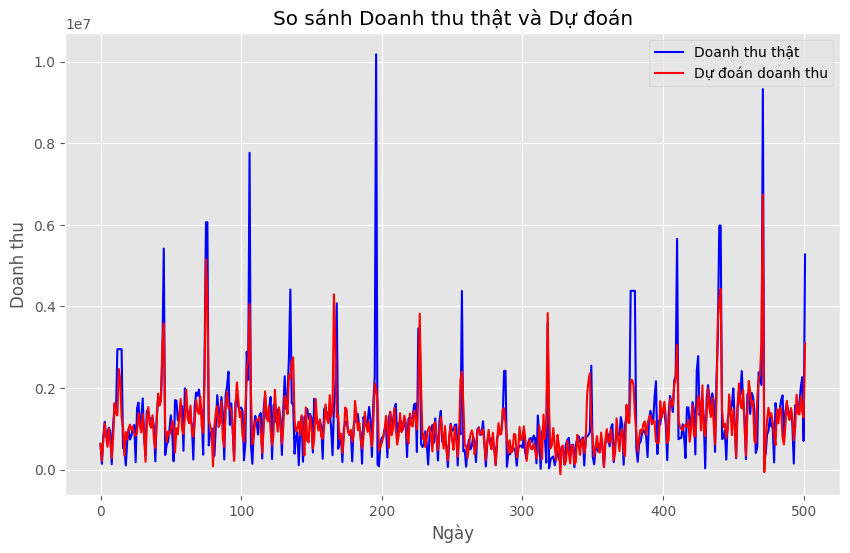

In [17]:
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Doanh thu thật')
plt.plot(predictions, color='red', label='Dự đoán doanh thu')
plt.title('So sánh Doanh thu thật và Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()
plt.show()

### Unit Sold LSTM

In [18]:
# Chuẩn hóa dữ liệu (Scaling từ 0 đến 1)
scaler = MinMaxScaler(feature_range=(0, 1))
sc_train = scaler.fit_transform(train_units)
sc_test = scaler.transform(test_units)

# Chuyển đổi dữ liệu thành dạng có thể sử dụng cho LSTM (sequence data)
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Tạo dữ liệu đầu vào cho mô hình LSTM
time_step = 45  # Sử dụng dữ liệu của 45 ngày trước đó để dự đoán ngày tiếp theo
X_train, y_train = create_dataset(sc_train, time_step)
X_test, y_test = create_dataset(sc_test, time_step)

# Reshape dữ liệu cho LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Sử dụng ModelCheckpoint để lưu mô hình tốt nhất
save_model = "/content/drive/MyDrive/2025/demo_unit_model.keras"
best_model = ModelCheckpoint(save_model, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
model.fit(X_train, y_train, epochs=80, batch_size=32, verbose=2, validation_data=(X_test, y_test), callbacks=[best_model])

# Dự đoán doanh thu cho tập test
predictions = model.predict(X_test)

# Chuyển đổi dự đoán trở lại giá trị gốc (denormalization)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/80

Epoch 1: val_loss improved from inf to 0.00185, saving model to /content/drive/MyDrive/2025/demo_unit_model.keras
119/119 - 15s - 126ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 2/80

Epoch 2: val_loss improved from 0.00185 to 0.00154, saving model to /content/drive/MyDrive/2025/demo_unit_model.keras
119/119 - 11s - 91ms/step - loss: 0.0066 - val_loss: 0.0015
Epoch 3/80

Epoch 3: val_loss did not improve from 0.00154
119/119 - 9s - 75ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 4/80

Epoch 4: val_loss did not improve from 0.00154
119/119 - 11s - 93ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 5/80

Epoch 5: val_loss improved from 0.00154 to 0.00151, saving model to /content/drive/MyDrive/2025/demo_unit_model.keras
119/119 - 20s - 170ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 6/80

Epoch 6: val_loss did not improve from 0.00151
119/119 - 21s - 173ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 7/80

Epoch 7: val_loss improved from 0.00151 to 0.00147, saving mode

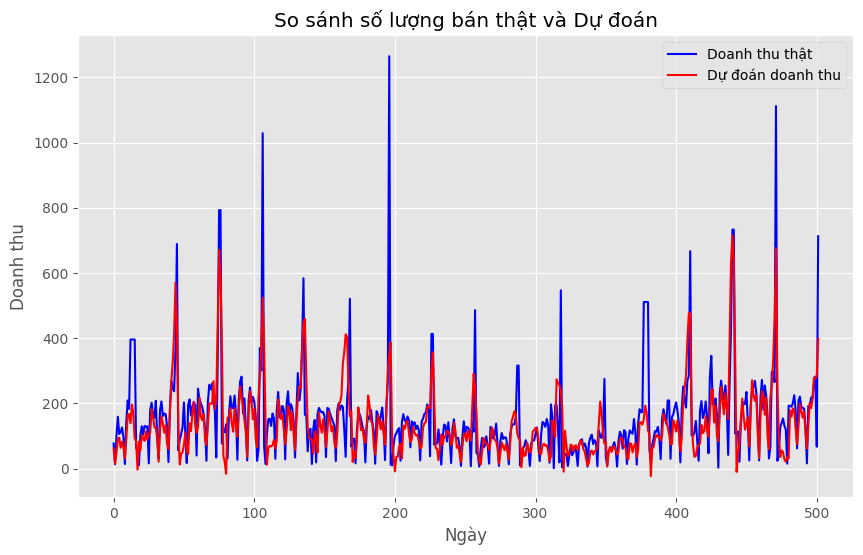

In [20]:
# Vẽ biểu đồ so sánh kết quả
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, color='blue', label='Doanh thu thật')
plt.plot(predictions, color='red', label='Dự đoán doanh thu')
plt.title('So sánh số lượng bán thật và Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()
plt.show()

In [21]:
#r2
print('R^2:',r2_score(y_test_actual,predictions))
#RMSE
print('RMSE tập test:',np.sqrt(mean_squared_error(y_test_actual,predictions)))
#mae
print('MAPE tập test:',mean_absolute_percentage_error(y_test_actual,predictions))

R^2: 0.4569681037150112
RMSE tập test: 102.71665343100706
MAPE tập test: 1.2353722254321562
